In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from IPython.display import Image
import datetime
import os

from sklearn.model_selection import train_test_split
from keras import backend as K

In [6]:
# Load data as path, filename, kind in subfolder 'Data'
root_path = os.path.join(os.getcwd(), "Data")
print(root_path)
data = pd.DataFrame()

for subfolder in os.listdir(root_path):
    subfolder_path = os.path.join(root_path, subfolder)
    if os.path.isdir(subfolder_path):  # Check if it's a directory
        files = [file for file in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, file))]
        for file in files:
            file_path = os.path.join(subfolder_path, file)
            file_name, _ = os.path.splitext(os.path.basename(file_path))
            path_without_extension = os.path.splitext(os.path.basename(file_path))[0]
            x = [[file_path, file_name, subfolder]]
            x = pd.DataFrame(x)
            data = pd.concat([data, x])
            
data = data.set_axis(['path', 'filename', 'kind'], axis='columns')
data

c:\Users\Haroon\Documents\Resume_classifier\Data


,path,filename,kind
0,c:\Users\Haroon\Documents\Resume_classifier\Da...,doc_000042,email
0,c:\Users\Haroon\Documents\Resume_classifier\Da...,doc_000046,email
0,c:\Users\Haroon\Documents\Resume_classifier\Da...,doc_000076,email
0,c:\Users\Haroon\Documents\Resume_classifier\Da...,doc_000079,email
0,c:\Users\Haroon\Documents\Resume_classifier\Da...,doc_000111,email
...,...,...,...
0,c:\Users\Haroon\Documents\Resume_classifier\Da...,doc_000845,scientific_publication
0,c:\Users\Haroon\Documents\Resume_classifier\Da...,doc_000864,scientific_publication
0,c:\Users\Haroon\Documents\Resume_classifier\Da...,doc_000891,scientific_publication
0,c:\Users\Haroon\Documents\Resume_classifier\Da...,doc_000942,scientific_publication


In [ ]:
Image(data.iloc[0,0])

In [110]:
Labels = data['kind'].unique()
I_L = {label: index for index, label in enumerate(Labels)}
key_map = {index: label for index, label in enumerate(Labels)}
I_L

{'scientific_publication': 0, 'resume': 1, 'email': 2}

In [111]:
X = data['path']
Y = data['kind'].map(I_L)

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
len(X_train),len(y_train),len(y_test),len(X_test)

(132, 132, 33, 33)

In [113]:
# some constants
IMG_SIZE = 128
BATCH_SIZE = 165
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SHAPE = len(Labels)

In [114]:
# utility functions
def process_img(path, size=(IMG_SIZE, IMG_SIZE)):   
    """convert image at some path to tensor"""
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # scale values [0-1]
    img = tf.image.resize(img, size)
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

def tuple_tensor(_x,y):
    """create tuple of image and label for train data"""
    
    return process_img(_x) , y

def d_batch(_x, y=None, batch_size=BATCH_SIZE, testdata=False):
    if testdata:
        print("test batch")
        d = tf.data.Dataset.from_tensor_slices(_x)
        data_batch = d.batch(batch_size)
        return data_batch
    else:
        print("train batch")
        d = tf.data.Dataset.from_tensor_slices((_x, tf.constant(y)))
        d = d.shuffle(buffer_size=len(_x))
        d = d.map(tuple_tensor)
        data_batch = d.batch(batch_size)
        return data_batch

def unbatch(bat, is_test=False):
    """
    Unbatch dataset of (image, label) tensor
    Return array of image array of label
    """
    img_ = []
    lab_ = []

    for batch_img in bat.unbatch().as_numpy_iterator():
        if is_test:
            img_.extend(batch_img)
            lab_.extend([None] * len(batch_img))
        else:
            img_, lab_ = zip(*batch_img)
            img_.extend(img_)
            lab_.extend(lab_)

    return img_, lab_

def save_model(m,suffix =None):
    """Save the model and append extra info to name"""
    d= os.path.join("saved_models",datetime.datetime.now().strftime('%Y-%m-%d-%H-%M'))
    path =d + "-" + suffix + ".keras"
    print("saving")
    m.save(path)
    return path

In [115]:
train_data = d_batch(X_train, y_train)
test_data = d_batch(X_test, y_test, testdata=True)

train batch
test batch


In [116]:
# callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=3,
    restore_best_weights=True
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=os.path.join("logs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
)

In [117]:
# metrics
def recall_m(y_true, y_pred):
    """calculate recall"""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    """calculate precision"""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    """calculate f1 score"""
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [118]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2",
                   input_shape=[IMG_SIZE,IMG_SIZE,3], trainable=False),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                        activation="softmax")
])
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["acc",f1_m,precision_m, recall_m]
)

model.build(INPUT_SHAPE)
X_train_preprocessed = tf.concat([process_img(path) for path in X_train], axis=0)
model.summary()
model.fit(X_train_preprocessed, y_train, epochs=100, batch_size=BATCH_SIZE,callbacks=[
    early_stopping_callback,
    tensorboard_callback
])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_11 (KerasLayer  (None, 1001)              1692489   
 )                                                               
                                                                 
 dense_11 (Dense)            (None, 3)                 3006      
                                                                 
Total params: 1695495 (6.47 MB)
Trainable params: 3006 (11.74 KB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.4525 - acc: 0.3030 - f1_m: 1.1782 - precision_m: 1.0439 - recall_m: 1.3523
Epoch 2/100
1/1 [==============================] - 0s 70ms/step - loss: 1.1174 - acc: 0.4545 - f1_m: 1.2209 - precision_m: 1.2500 - recall_m: 1.1932
Epoch 3/100
1/1 [==============================

In [119]:
%tensorboard --dir C:\Users\Haroon\Documents\VS-Code\py\TensorFlow_\logs

UsageError: Line magic function `%tensorboard` not found.


2/2 [==============================] - 0s 8ms/step


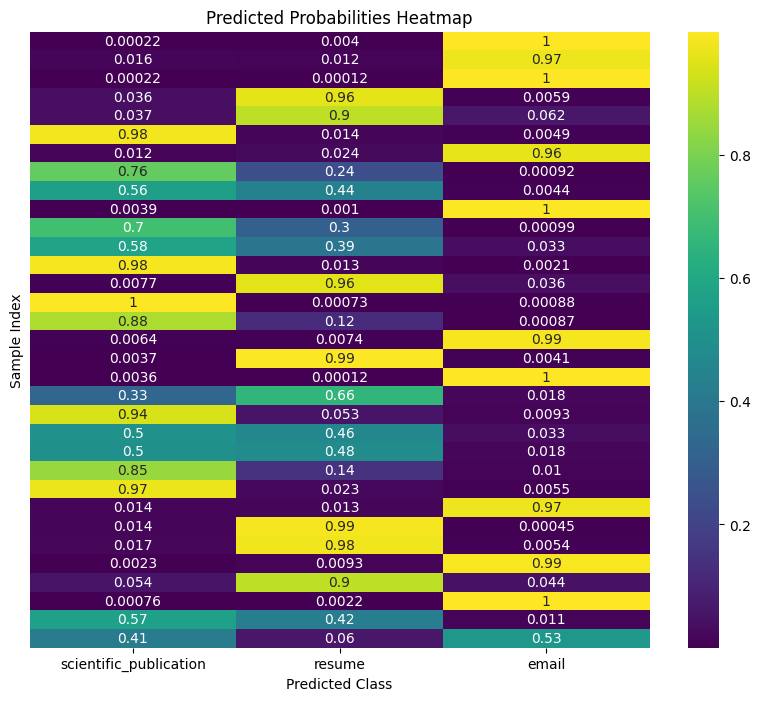

In [132]:
X_test_preprocessed = tf.concat([process_img(path) for path in X_test], axis=0)
pred_probs = model.predict(X_test_preprocessed)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pred_probs, annot=True, cmap='viridis', xticklabels=Labels, yticklabels=False, ax=ax)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Sample Index')
ax.set_title('Predicted Probabilities Heatmap')
plt.show()

<Axes: >

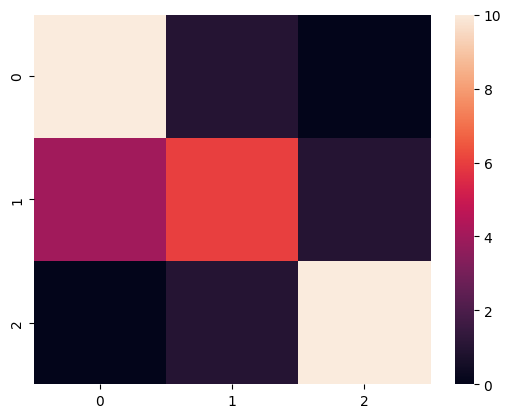

In [127]:
cfm =tf.math.confusion_matrix(labels=y_test,predictions=tf.argmax(pred_probs,axis=1))
sns.heatmap(cfm)

In [123]:
model.evaluate(X_test_preprocessed, y_test)

2/2 [==============================] - 0s 30ms/step - loss: 0.4662 - acc: 0.7879 - f1_m: 0.9038 - precision_m: 0.8387 - recall_m: 1.0000


[0.4661817252635956,
 0.7878788113594055,
 0.903846025466919,
 0.8387095928192139,
 0.9999999403953552]

In [130]:
save_model(model,suffix ="resume_class_128_mobilenetv2")

saving


/home/haroon/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'saved_models/2023-12-20-23-24-.h5'